In [1]:
import os
import pickle

import numpy as np
import torch

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, random_split
from torch.nn.functional import one_hot

from data_loaders.pulja_data_loader import PuljaDataLoader
from models._20220523_00 import UserModel
from models.utils import collate_fn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor, LongTensor

In [2]:
ckpt_path = "ckpts"
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)

batch_size = 256
num_epochs = 100
train_ratio = 0.9

seq_len = 100

dim_v = 20

dataset = PuljaDataLoader(seq_len)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

model = UserModel(dataset.num_c, dataset.num_d, dim_v).to(device)

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset, [train_size, test_size]
)

if os.path.exists(os.path.join(dataset.dataset_dir, "indices.pkl")):
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "rb") as f:
        indices = pickle.load(f)
    train_dataset.indices = indices[0]
    test_dataset.indices = indices[1]
else:
    with open(os.path.join(dataset.dataset_dir, "indices.pkl"), "wb") as f:
        pickle.dump((train_dataset.indices, test_dataset.indices), f)


In [3]:
model.load_state_dict(
    torch.load(os.path.join(ckpt_path, "model.ckpt"), map_location=device)
)
model.eval()

UserModel(
  (D1): Embedding(7, 1)
  (D2): Embedding(7, 20)
  (gru): GRU(40, 20, batch_first=True)
  (linear_1): Sequential(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear_2): Sequential(
    (0): Linear(in_features=60, out_features=20, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=20, out_features=1, bias=True)
    (4): Dropout(p=0.5, inplace=False)
  )
)

In [4]:
test_dataset[13]

(array([22, 22, 22, 22, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 22, 22]),
 array([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 2, 2,
        2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([0.        , 0.        , 0.        , 0.        , 0.77124183,
        0.66666667, 1.        , 0.77124183, 0.50980392, 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.       

In [6]:
c_seq, d_seq, r_seq = test_dataset[13] # 0, 2, 3, 4, 5, 7, 8, 9, 10, 13

c_seq, cshft_seq, d_seq, dshft_seq, r_seq, rshft_seq = \
[c_seq[:-1]], [c_seq[1:]], [d_seq[:-1]], [d_seq[1:]], [r_seq[:-1]], [r_seq[1:]]

# r_seq = np.zeros_like(r_seq)
# r_seq = np.ones_like(r_seq)

###########################################
# alpha_seq, beta_seq, beta_shft_seq, gamma_seq, gamma_shft_seq, h_seq, C_seq = model(
#     LongTensor(c_seq),
#     LongTensor(cshft_seq),
#     LongTensor(d_seq),
#     LongTensor(dshft_seq),
#     FloatTensor(r_seq),
# )
###########################################
alpha_seq, h_seq, C_seq = model(
    LongTensor(c_seq),
    LongTensor(d_seq),
    FloatTensor(r_seq),
)

# c_one_hot_seq: [batch_size, seq_len, 1, num_c]
c_one_hot_seq = one_hot(LongTensor(c_seq), model.num_c).float()
c_one_hot_seq = torch.reshape(
    c_one_hot_seq,
    shape=[
        -1,
        c_one_hot_seq.shape[1],
        c_one_hot_seq.shape[2]
    ]
).unsqueeze(-2)
beta_seq = torch.bmm(
    torch.reshape(
        c_one_hot_seq,
        shape=[
            -1,
            c_one_hot_seq.shape[2],
            c_one_hot_seq.shape[3]
        ]
    ),
    torch.reshape(
        C_seq, shape=[-1, C_seq.shape[2], C_seq.shape[3]]
    )
)
beta_seq = torch.reshape(
    beta_seq, shape=[1, seq_len]
)

gamma_seq = model.D1(LongTensor(d_seq)).squeeze()
###########################################

sigmoid_alpha_seq = torch.sigmoid(alpha_seq).detach().cpu().numpy()

sigmoid_alpha_beta_seq = torch.sigmoid(alpha_seq + beta_seq).detach().cpu().numpy()[0]

sigmoid_alpha_beta_gamma_seq = torch.sigmoid(alpha_seq + beta_seq - gamma_seq).detach().cpu().numpy()[0]

CQ_seq = torch.sigmoid(C_seq.squeeze() + alpha_seq.unsqueeze(-1)).detach().cpu().numpy()
C_seq = C_seq.squeeze().detach().cpu().numpy()

# alpha_seq = alpha_seq.detach().cpu().numpy()

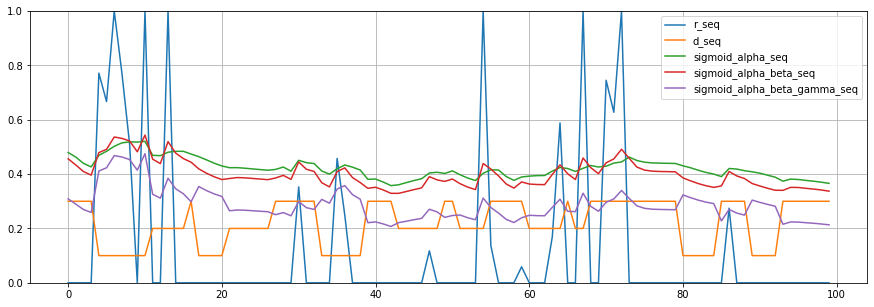

In [7]:
plt.figure(figsize=[15, 5], facecolor="white")
plt.plot(r_seq[0], label="r_seq")
plt.plot((d_seq[0] + 1) / 10, label="d_seq")
plt.plot(sigmoid_alpha_seq, label="sigmoid_alpha_seq")
plt.plot(sigmoid_alpha_beta_seq, label="sigmoid_alpha_beta_seq")
plt.plot(sigmoid_alpha_beta_gamma_seq, label="sigmoid_alpha_beta_gamma_seq")
plt.grid()
plt.ylim(0, 1)
plt.legend()
plt.show()

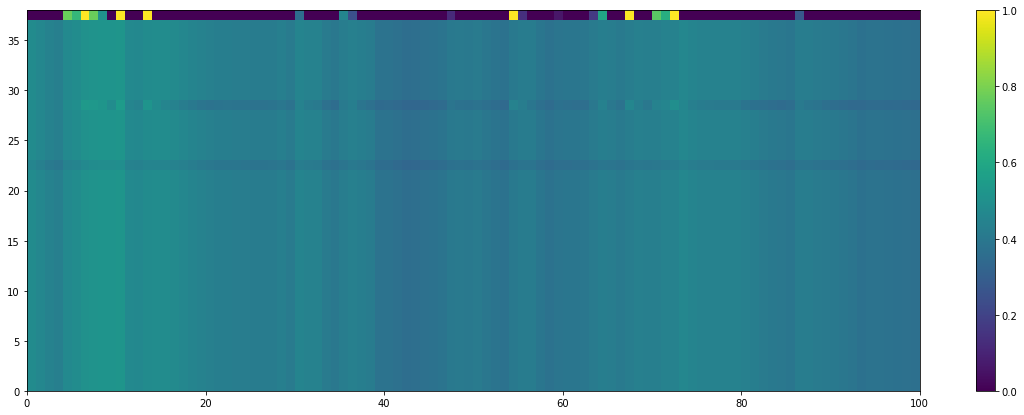

In [8]:
plt.figure(figsize=[20, 7], facecolor="white")
temp = np.concatenate([CQ_seq.T, r_seq], axis=0)
plt.pcolormesh(temp)
plt.colorbar()
plt.show()

# plt.figure(figsize=[15, 0.5], facecolor="white")
# plt.pcolormesh(r_seq)
# plt.show()

In [9]:
CQ_seq[-1]

array([0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.33727142, 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.3658593 , 0.3372347 , 0.3658593 ,
       0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 , 0.3658593 ,
       0.3658593 , 0.3658593 ], dtype=float32)

In [10]:
model.D1.weight

Parameter containing:
tensor([[0.2744],
        [0.5463],
        [0.6299],
        [0.5518],
        [0.5203],
        [0.4488],
        [0.8324]], requires_grad=True)